In [3]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [55]:
import ipynb.fs.full.helper as h

from imp import reload
reload(h)

<module 'ipynb.fs.full.helper' (/tf/src/scripts/helper.ipynb)>

In [6]:
directory = h.directory
OC_Net = h.OC_Net
df = h.df
image_directory = h.image_directory

df.head(10)

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask
5,6427.png,218,98,577,580,face_with_mask_incorrect
6,6427.png,278,386,582,582,mask_surgical
7,4591.png,239,9,522,342,face_with_mask
8,4591.png,255,159,491,341,mask_colorful
9,5392.jpg,261,0,444,257,face_other_covering


In [7]:
data = []
img_size = 224
mask_describe = ['face_with_mask',"face_no_mask"]
labels={'mask':0,'without mask':1}
type_mask = []
fileste= ".json"

def get_bounding(j,i,data,labels_item):
    x,y,w,h = j["BoundingBox"]
    img = cv2.imread(os.path.join(image_directory,i),1)
    img = img[y:h,x:w]
    img = cv2.resize(img,(img_size,img_size))
    data.append([img,labels_item])
    
def get_json_file(PathName):
    with open(PathName,'r') as f:
        return json.load(f)

for i in df["name"].unique():
    f = i+fileste
    for j in get_json_file(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask_describe[0]:
            get_bounding(j,i,data,labels['mask'])
            type_mask.append(labels['mask'])
            
        if j["classname"] in mask_describe[1]:
            get_bounding(j,i,data,labels['without mask'])
            type_mask.append(labels['without mask'])

random.shuffle(data)  

In [10]:
sns.countplot(type_mask)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

In [11]:
features = []
labels = []
for f,l in data:
    features.append(f)
    labels.append(l)

In [12]:
features[0].shape

(224, 224, 3)

In [13]:
features = np.array(features)/255.0
features = features.reshape(-1,img_size,img_size,3)
labels = np.array(labels)

print(np.unique(labels))
print(features.shape)

[0 1]
(5749, 224, 224, 3)


In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2

base_model_mobile = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

for layer in base_model_mobile.layers:
    layer.trainable = False
    
model_mobile = Sequential()
model_mobile.add(base_model_mobile)
model_mobile.add(Flatten())
model_mobile.add(Dense(1,activation='sigmoid'))
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1)                 62721     
                                                                 
Total params: 2,320,705
Trainable params: 62,721
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
train_f,val_f,train_l,val_l=train_test_split(features, labels,train_size=0.8,random_state=0)
datagen = ImageDataGenerator(
        rotation_range= 17,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        zca_epsilon = 1e-05, 
        horizontal_flip=True, 
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        brightness_range = [0.1, 10], 
)
datagen.fit(train_f)

In [16]:
model_mobile.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

history_mobile = model_mobile.fit(datagen.flow(train_f, train_l, batch_size=32),
                   steps_per_epoch=train_f.shape[0]//32,
                   epochs=15,
                   verbose=1,
                   validation_data=(val_f, val_l))


Epoch 1/15
143/143 [==============================] - 30s 184ms/step - loss: 1.2445 - accuracy: 0.7935 - val_loss: 0.4630 - val_accuracy: 0.9217
Epoch 2/15
143/143 [==============================] - 25s 177ms/step - loss: 1.0657 - accuracy: 0.8353 - val_loss: 0.4014 - val_accuracy: 0.9235
Epoch 3/15
143/143 [==============================] - 25s 178ms/step - loss: 1.1354 - accuracy: 0.8404 - val_loss: 0.3851 - val_accuracy: 0.9322
Epoch 4/15
143/143 [==============================] - 25s 176ms/step - loss: 1.2317 - accuracy: 0.8483 - val_loss: 0.8231 - val_accuracy: 0.9096
Epoch 5/15
143/143 [==============================] - 25s 177ms/step - loss: 1.2317 - accuracy: 0.8494 - val_loss: 0.6597 - val_accuracy: 0.9217
Epoch 6/15
143/143 [==============================] - 26s 178ms/step - loss: 1.1484 - accuracy: 0.8636 - val_loss: 0.4651 - val_accuracy: 0.9417
Epoch 7/15
143/143 [==============================] - 25s 176ms/step - loss: 1.5533 - accuracy: 0.8540 - val_loss: 0.6105 - val_ac

In [17]:
history_list = []
history_list.append(history_mobile)

In [42]:
model_mobile.evaluate(val_f, val_l)
prediction_mobile = model_mobile.predict(val_f)

36/36 [==============================] - 1s 34ms/step - loss: 0.7827 - accuracy: 0.9357


ResourceExhaustedError:  OOM when allocating tensor with shape[32,96,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/mobilenetv2_1.00_224/block_1_expand/Conv2D
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py:231)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_56908]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/mobilenetv2_1.00_224/block_1_expand/Conv2D:
In[0] sequential/mobilenetv2_1.00_224/expanded_conv_project_BN/FusedBatchNormV3 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py:605)	
In[1] sequential/mobilenetv2_1.00_224/block_1_expand/Conv2D/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 505, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-28-6aabb62c4b44>", line 29, in <module>
>>>     label_Y,result = get_label(frame,img_size)
>>> 
>>>   File "<ipython-input-27-9d70ae61f3aa>", line 12, in get_label
>>>     result = model.predict(im)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1789, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1621, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1611, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1604, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1572, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

In [23]:
model_mobile.save(h.modelsVMask)

INFO:tensorflow:Assets written to: /tf/src/models//v69/objdet_mask/assets


INFO:tensorflow:Assets written to: /tf/src/models//v69/objdet_mask/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


AxesSubplot(0.125,0.125;0.775x0.755)


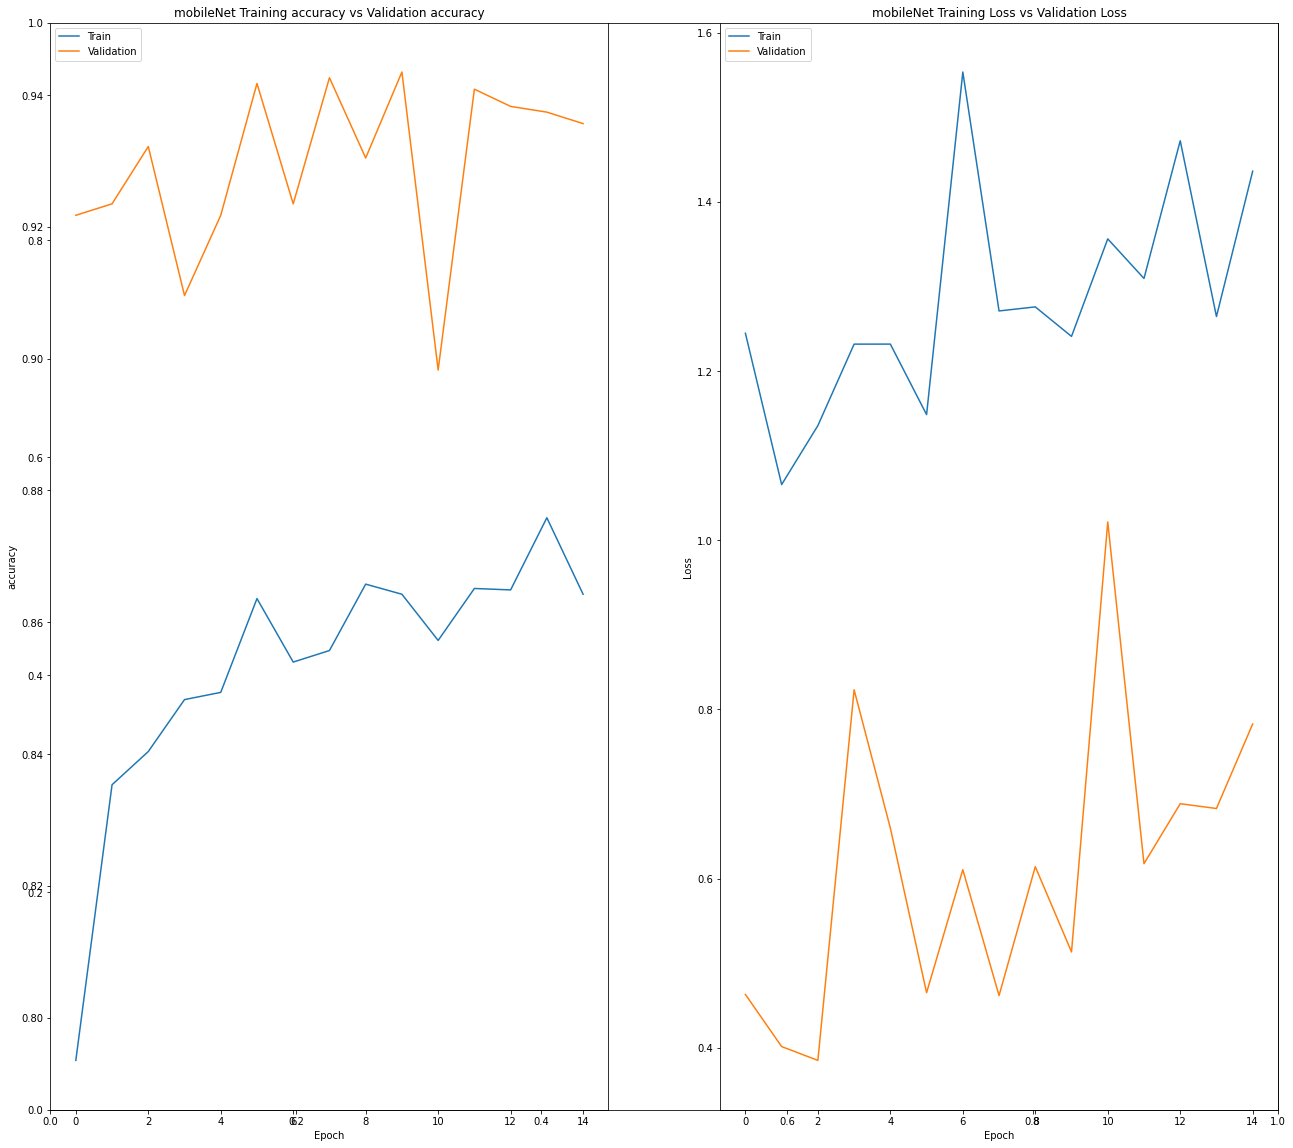

In [24]:
import numpy
import pandas 
import matplotlib.pyplot as plt
%matplotlib inline

#1 
fig,ax = plt.subplots(figsize=(22,20))

print(ax)
ax7 = fig.add_subplot(1,2,1)
ax8 = fig.add_subplot(1,2,2)

#3
ax7.plot(history_mobile.history['accuracy'])
ax7.plot(history_mobile.history['val_accuracy'])
ax7.set_title('mobileNet Training accuracy vs Validation accuracy')
ax7.set_ylabel('accuracy')
ax7.set_xlabel('Epoch')
ax7.legend(['Train', 'Validation'], loc='upper left')

ax8.plot(history_mobile.history['loss'])
ax8.plot(history_mobile.history['val_loss'])
ax8.set_title('mobileNet Training Loss vs Validation Loss')
ax8.set_ylabel('Loss')
ax8.set_xlabel('Epoch')
ax8.legend(['Train', 'Validation'], loc='upper left')

In [53]:
def extract_face(face):
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def get_label(frame,img_size):
    im = cv2.resize(frame,(img_size,img_size))
    im = np.array(im)/255.0
    im = im.reshape(1,img_size,img_size,3)
    result = model.predict(im)
    label_Y=1 if result>0.3 else 0
    return label_Y,result

In [58]:
# 4 images to test and display
test_img = ["0015.jpg","0834.jpg","0675.jpg","1035.jpeg"]
image_test_directory = h.image_test_directory

0 [[2.020559e-20]]
1 [[1.]]
1
0834.jpg
0 [[2.544352e-30]]
0 [[6.6222254e-28]]
0 [[2.6781321e-21]]
1 [[1.]]
1
1035.jpeg
0 [[4.6507784e-27]]


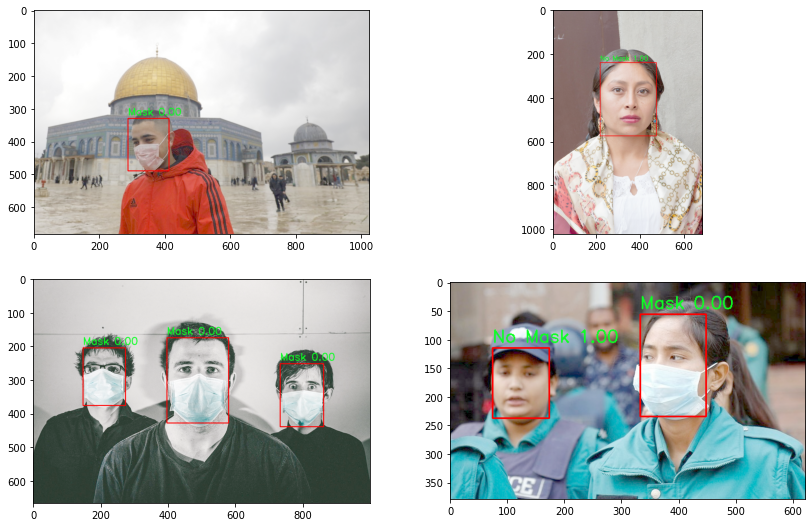

In [59]:
model = model_mobile

# adjust image darker and light 
adjust_light,rows,cols = 2.2,3,2
figure= plt.figure(figsize = (14,14))
axes = []
assign = {'0':'Mask','1':"No Mask"}
face_list = [] # save no mask

for j,im in enumerate(test_img):
    image =  cv2.imread(os.path.join(image_test_directory,im),1)
    back_image = image
    image = cv2.LUT(image.astype(np.uint8), np.array([((i / 255.0) ** (1.0 / adjust_light)) * 255 for i in np.arange(0, 256)]).astype(np.uint8))
    blob = cv2.dnn.blobFromImage(image=cv2.resize(image, (300,300)), scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
    
    OC_Net.setInput(blob)
    detections = OC_Net.forward()
    length = detections.shape[2]
    (hight, width) = image.shape[:2]
    for i in range(0, length):
        # get the face box
        boxs = detections[0, 0, i, 3:7] * np.array([width, hight, width, hight])
        (startX, startY, endX, endY) = boxs.astype("int")
        frame = image[startY:endY, startX:endX]
        
        # according to the confidence_threshold, to get the label
        confidence_threshold = detections[0, 0, i, 2]
        if confidence_threshold > 0.4:
            label_Y,result = get_label(frame,img_size)
            print(label_Y,result)
           
            # add the Text
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv2.putText(image,assign[str(label_Y)] + "{: .2f}".format(float(result)) , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)
            
            ## save nomask people mesage
            if(label_Y==1):
                print("1")
#                     plt.imshow(back_image)
                face_list.append(im)
                print(im)

    axes.append(figure.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()